## Missing Data Analysis

After merging all datasets (wind power, weather, spot prices, balancing prices) into the 
combined **X-table**, we examined the coverage of each feature over time.

### Step 1: Visualizing missingness
- Created a **heatmap** where:
  - **X-axis** = timeline (hours),
  - **Y-axis** = features,
  - **Black** = available data,
  - **White** = missing values.
- This gave a quick overview of where each feature had continuous data and where gaps exist.
- Observations:
  - Wind power data starts only from **2021**.
  - Weather is mostly continuous, but with occasional short gaps.
  - Balancing prices have irregular coverage and some large missing blocks.
  - Spot prices are dense and aligned, with only minor missingness.

### Step 2: Quantifying gaps
- Implemented a gap-detection function that:
  - Iterates through each feature.
  - Finds **consecutive NaN streaks**.
  - Measures their length in **hours and days**.
- Used a **threshold of 10 days (240 hours)** to report only the significant gaps.

## lets change the threshold of consecutive days (a rough assumption on what we consider of importance as a consecutive loss of data)


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- Paths ---
base_dir = r"D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\ProcessedData"
out_path = os.path.join(base_dir, "X_table.csv")

# --- Load datasets ---
df_power = pd.read_csv(os.path.join(base_dir, "WPP_Snorrebakken_Bornholm_hourly.csv"), parse_dates=["ts"], index_col="ts")
df_weather = pd.read_csv(os.path.join(base_dir, "Weather_Hourly_Clean.csv"), parse_dates=["ts"], index_col="ts")
df_spot = pd.read_csv(os.path.join(base_dir, "Spot_Prices_Hourly_DK2_SYSTEM.csv"), parse_dates=["ts"], index_col="ts")
df_bal = pd.read_csv(os.path.join(base_dir, "Balancing_Price_Hourly_DK2_clean.csv"), parse_dates=["ts"], index_col="ts")

# --- Merge all on timestamp (outer join: keep all hours) ---
df_X = pd.concat([df_power, df_weather, df_spot, df_bal], axis=1)

# --- Save full table ---
df_X.to_csv(out_path)

print("Final X table shape:", df_X.shape)
print("Saved to:", out_path)




Final X table shape: (43848, 24)
Saved to: D:\WORK\4_STUDENT_DTU\OneDrive - Danmarks Tekniske Universitet\12_Semesters\5_13week_courses\46765_MachineLearning_EnergySystems\0.MachineLearning_EenrgySystems_Assignments\ProcessedData\X_table.csv


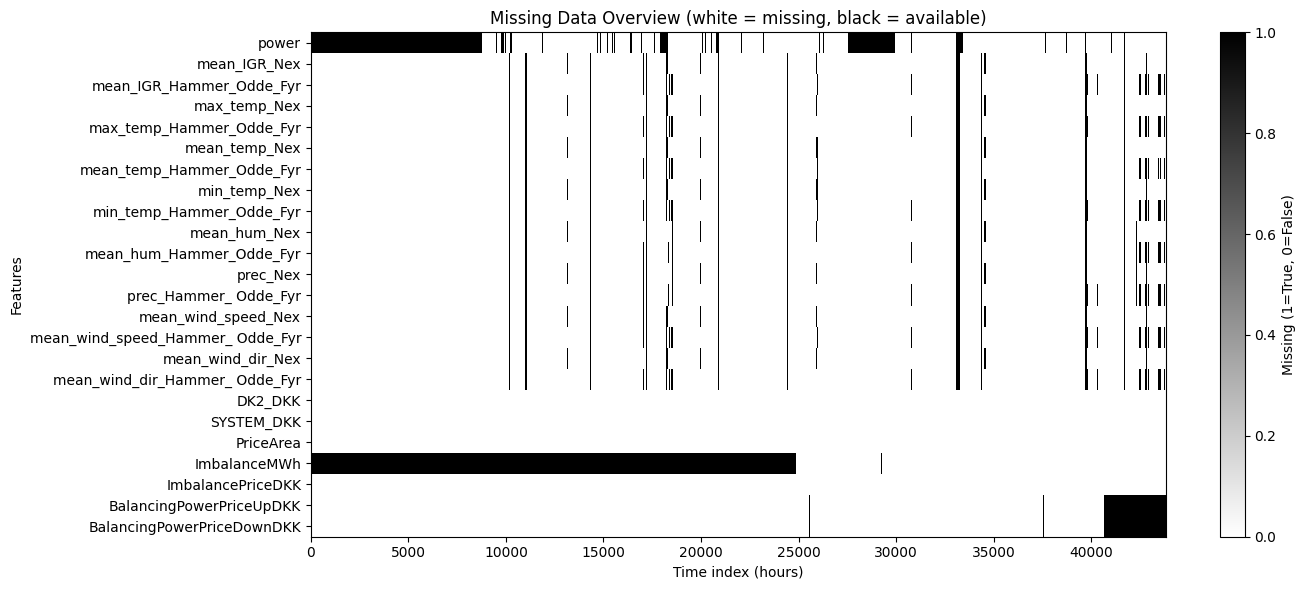

In [3]:
# --- Plot missing values (intuitive heatmap) ---
plt.figure(figsize=(14,6))
plt.imshow(df_X.isna().T, aspect="auto", cmap="gray_r", interpolation="none")
plt.yticks(range(len(df_X.columns)), df_X.columns)
plt.xlabel("Time index (hours)")
plt.ylabel("Features")
plt.title("Missing Data Overview (white = missing, black = available)")
plt.colorbar(label="Missing (1=True, 0=False)")
plt.tight_layout()
plt.show()


In [5]:
def find_gaps(df, threshold_hours=120):  # default = 5 days
    gap_report = {}

    for col in df.columns:
        isna = df[col].isna().astype(int)
        gaps = []
        count = 0
        start_idx = None

        for i, val in enumerate(isna):
            if val == 1:
                if count == 0:
                    start_idx = df.index[i]
                count += 1
            elif count > 0:
                if count >= threshold_hours:
                    gaps.append((start_idx, df.index[i-1], count))
                count = 0
                start_idx = None

        # Handle if series ends with a gap
        if count >= threshold_hours:
            gaps.append((start_idx, df.index[-1], count))

        if gaps:
            gap_report[col] = gaps

    return gap_report

# Example usage:
gap_report = find_gaps(df_X, threshold_hours=240)  # 10 days
for col, gaps in gap_report.items():
    print(f"\nColumn: {col}")
    for start, end, length in gaps:
        print(f"  Gap from {start} to {end} ({length} hours ≈ {length/24:.1f} days)")


Column: power
  Gap from 2020-01-01 00:00:00 to 2020-12-31 23:00:00 (8784 hours ≈ 366.0 days)
  Gap from 2022-01-14 07:00:00 to 2022-01-31 08:00:00 (410 hours ≈ 17.1 days)
  Gap from 2023-02-20 23:00:00 to 2023-06-01 06:00:00 (2408 hours ≈ 100.3 days)
  Gap from 2023-10-08 22:00:00 to 2023-10-22 21:00:00 (336 hours ≈ 14.0 days)

Column: ImbalanceMWh
  Gap from 2020-01-01 00:00:00 to 2022-11-01 22:00:00 (24863 hours ≈ 1036.0 days)

Column: BalancingPowerPriceUpDKK
  Gap from 2024-08-19 05:00:00 to 2024-12-31 23:00:00 (3235 hours ≈ 134.8 days)

Column: BalancingPowerPriceDownDKK
  Gap from 2024-08-19 05:00:00 to 2024-12-31 23:00:00 (3235 hours ≈ 134.8 days)
